In [24]:
import torch
from models import get_model
import pickle
from dataset import get_dataset,get_dataset_subset
from fast_train import 

In [52]:
model = get_model('wrn28-2',10)
with open('demo_test/model_0.pkl','rb') as f:
    model.load_state_dict(pickle.load(f))
with open('demo_test/models_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

load the correct model


In [58]:
dataset  = get_dataset('cifar10', '../data')
train_index = metadata['model_metadata'][0]['train_split']
test_index = metadata['model_metadata'][0]['test_split']
audit_index = metadata['model_metadata'][0]['audit_split']
train_data, train_targets = get_dataset_subset(dataset, train_index)
test_data, test_targets = get_dataset_subset(dataset, test_index)
audit_data, audit_targets = get_dataset_subset(dataset, audit_index)

Load data from ../data/cifar10.pkl
the whole dataset size: 60000


In [59]:
with torch.no_grad():
    train_pred = model(train_data).detach()
    test_pred = model(test_data).detach()
    audit_pred = model(audit_data).detach()

In [174]:
T=8

train_score = -T * torch.logsumexp(train_pred/T, dim=1)
test_score = -T * torch.logsumexp(test_pred/T, dim=1)
audit_score = -T * torch.logsumexp(audit_pred/T, dim=1)

In [175]:
audit_score.mean(), train_score.mean()

loss_fun = torch.nn.CrossEntropyLoss(reduction='none')
train_loss = loss_fun(train_pred, train_targets)
test_loss = loss_fun(test_pred, test_targets)
audit_loss = loss_fun(audit_pred, audit_targets)

In [176]:
import numpy as np
train_corret = np.array([train_pred[idx,y] for idx, y in enumerate(train_targets)])
test_corret = np.array([test_pred[idx,y] for idx, y in enumerate(test_targets)])
audit_corret = np.array([audit_pred[idx,y] for idx, y in enumerate(audit_targets)])

train_wrong = np.array([torch.sum(np.exp(train_pred[idx])).item() - np.exp(train_pred[idx,y]) for idx, y in enumerate(train_targets)])
test_wrong = np.array([torch.sum(np.exp(test_pred[idx])).item() - np.exp(test_pred[idx,y]) for idx, y in enumerate(test_targets)])
audit_wrong = np.array([torch.sum(np.exp(audit_pred[idx])).item() - np.exp(audit_pred[idx,y]) for idx, y in enumerate(audit_targets)])

train_c_score = train_corret - np.log(train_wrong)
test_c_score = test_corret - np.log(test_wrong)
audit_c_score = audit_corret - np.log(audit_wrong)

In [135]:
train_c_score.mean(), test_c_score.mean()

(3.501553, 0.87114525)

In [169]:
bounary = torch.FloatTensor([-100,1000])
audit_score = torch.cat([audit_score, bounary])
audit_loss = torch.cat([audit_loss, torch.FloatTensor([-0.1,100])])
audit_c_score = np.concatenate([audit_c_score,np.array([-100,100])])

In [170]:
audit_loss

tensor([  0.2601,   1.5211,   0.6198,  ..., 100.0000,  -0.1000, 100.0000])

In [177]:
threshold = torch.sort(audit_score).values

fpr = []
tpr = []
fpr_loss = []
tpr_loss = []
fpr_c = []
tpr_c = []
for p in threshold:
    tpr.append(torch.mean((train_score<p).float()).item())
    fpr.append(torch.mean((test_score<p).float()).item())
    
threshold = torch.sort(audit_loss).values
for p in threshold:
    tpr_loss.append(torch.mean((train_loss<p).float()).item())
    fpr_loss.append(torch.mean((test_loss<p).float()).item())
    
    
threshold = np.sort(-audit_c_score)
for p in threshold:
    tpr_c.append(np.mean((train_c_score>-p)))
    fpr_c.append(np.mean((test_c_score>-p)))
    

In [178]:
import numpy as np
auc =  np.trapz(x=fpr, y=tpr)
auc_loss = np.trapz(x=fpr_loss, y = tpr_loss)
auc_c = np.trapz(x=fpr_c, y= tpr_c)
print(auc,auc_loss, auc_c)

0.6176126537656419 0.7340796483568541 0.7340797716049383


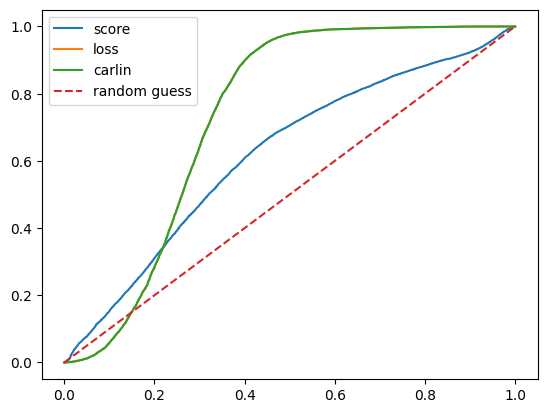

In [179]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='score')
plt.plot(fpr_loss, tpr_loss, label='loss')

plt.plot(fpr_c, tpr_c, label='carlin')
plt.plot([0,1],[0,1],ls='--', label='random guess')
plt.legend()